# Bird Call Classifier

In the field of machine learning, models are created to make decisions based on the data they are trained on. This decision-making process aims to emulate human-like reasoning but involves complex computations and methodologies. In this project, we will focus on a specific type of decision: classification.

Consider a scenario where you are outside, walking your dog, and you hear birds chirping. Although you cannot see the bird, you wish to classify which bird is making the sound. You look around and identify the bird as a cardinal. With enough exposure to cardinal songs, you would become adept at recognizing them.

Extending this further, you can listen to various bird calls and learn how their songs correlate to different species, potentially becoming an expert at identifying birds by their sounds.

While humans can learn this task through experience, creating a machine learning model to accomplish this is more intricate. Machines lack qualitative experience and can only "learn" from numerical representations. Therefore, our task is to translate the auditory experience of listening to bird songs into a format that a computer can process, capturing the nuances between different bird songs to enable accurate classification.

This project will guide you through this process. Since bird identification relies heavily on auditory cues, our data will consist of audio files from xeno-canto featuring songs from various bird species.

## Project Outline

1. **Data Collection** | Collect audio recordings of bird calls for a selected number of species. These recordings will form the basis of our dataset.

- Objective: Select a subset of bird species and gather a variety of their call samples.
- Implementation: Store the audio files in a directory structure under data/raw, with subdirectories for each species.

2. **Data Transformation** - Transform the raw audio data into formats suitable for machine learning. We will start with basic representations and move towards more sophisticated methods such as Spectrograms and Embeddings.

- Objective: Investigate how raw audio data can be represented for effective machine learning.
- Implementation: Explore different data representations such as Spectrograms and Embeddings, and evaluate their suitability for the task.

3. **Data Visualization and Analysis** | Visualize the transformed data to understand its structure and characteristics. Analyze how different transformations impact the classification task.


- Objective: Demonstrate the stages of data transformation.
- Implementation: Emphasize the shape and structure of the vectors representing the audio data, and analyze how each transformation impacts the model’s performance.

This project will provide a comprehensive framework for developing a bird call classifier using machine learning. It will demonstrate the importance of data transformation and feature extraction in building robust models capable of accurate classification.

## Step 1: Setup Directory and Install Required Packages
Our working directory is set-up within Google Drive. The directory can be cloned from this Github repo if you wish to run this on your computer or Google Account. Additionally, we are going to ensure essential python packages are installed.

In [1]:
from google.colab import drive
import os

# Set the desired directory path within your Google Drive
drive.mount("/content/drive", force_remount=True)
mount_point = '/content/drive/MyDrive/birdcall-classifier'

# Check if the directory exists
if os.path.exists(mount_point):
    # Change the current working directory to the specified path
    os.chdir(mount_point)
    print(f"Changed current directory to {mount_point}")
else:
    print(f"The directory {mount_point} does not exist in your Google Drive.")

!pip install -q resampy noisereduce



Mounted at /content/drive
Changed current directory to /content/drive/MyDrive/birdcall-classifier


# Step 2: Load and Process Audio Files

Audio processing is a crucial step in understanding and analyzing audio data. We will segment audio files into fixed lengths to ensure uniformity. Segmentation helps in capturing different parts of the audio signal, which might contain distinct features. The segmentation process involves dividing the audio file into smaller chunks of equal length, allowing us to analyze each chunk individually.

Processing file: XC545364.mp3 from blue-jay
Total segments: 12
Total kept segments: 2
Total rejected segments: 10
Playing kept segment 1 of XC545364.mp3 from blue-jay


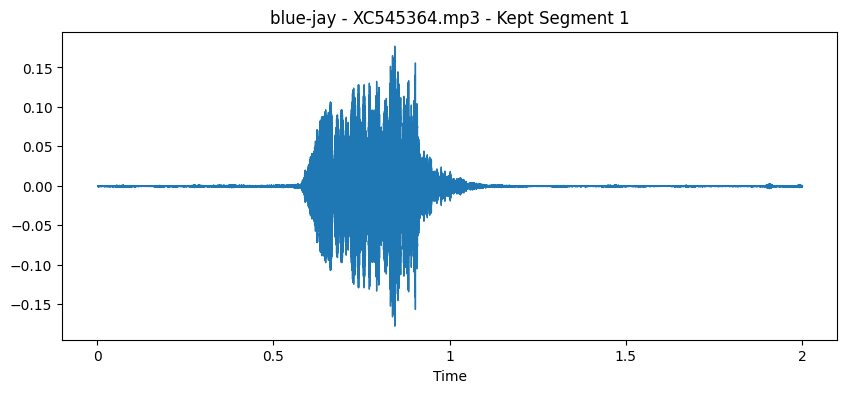

Playing kept segment 2 of XC545364.mp3 from blue-jay


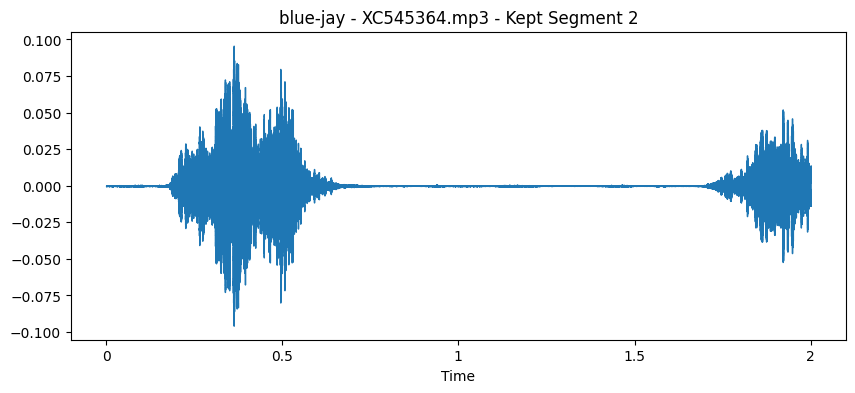

Playing rejected segment 1 of XC545364.mp3 from blue-jay


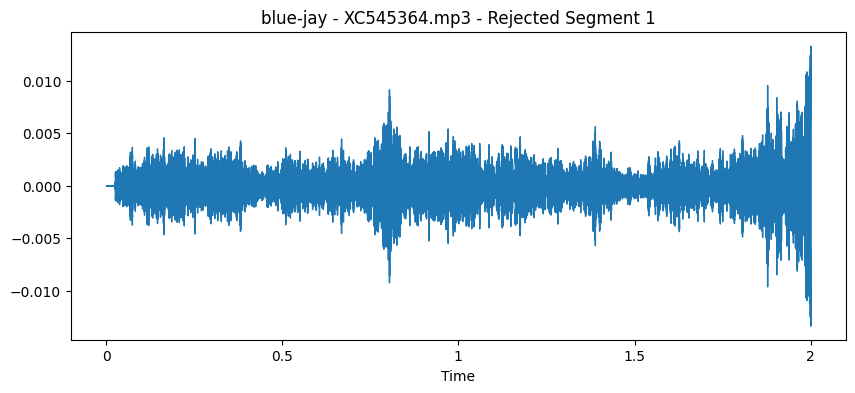

Playing rejected segment 2 of XC545364.mp3 from blue-jay


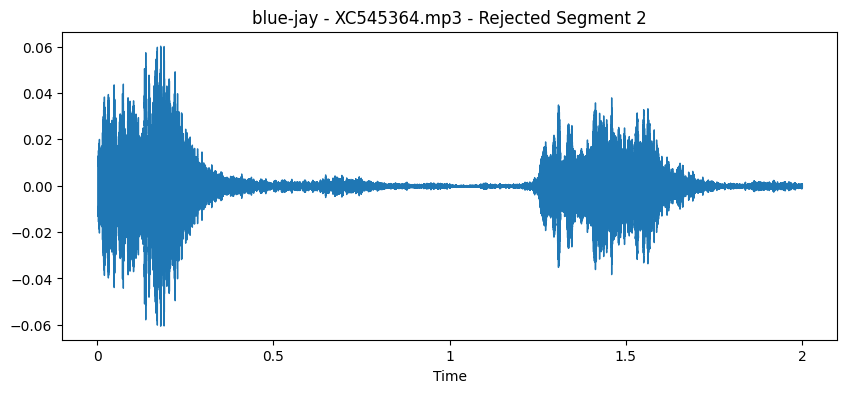

Shape of kept segment: (32000,)
Processing file: XC877641 - Northern Cardinal - Cardinalis cardinalis.wav from cardinal
Total segments: 19
Total kept segments: 9
Total rejected segments: 10
Playing kept segment 1 of XC877641 - Northern Cardinal - Cardinalis cardinalis.wav from cardinal


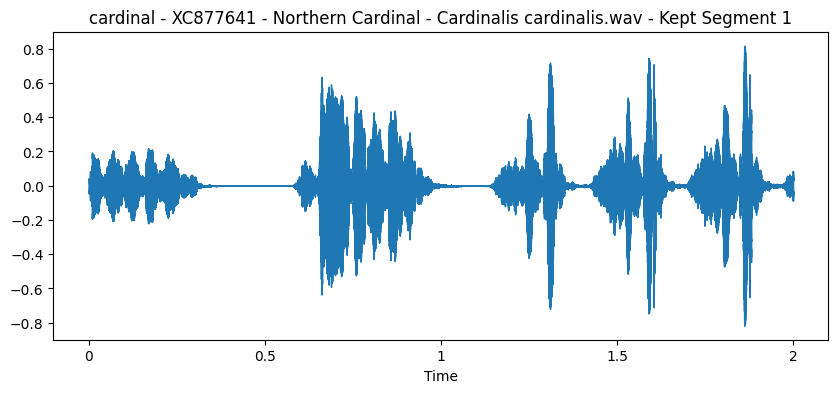

Playing kept segment 2 of XC877641 - Northern Cardinal - Cardinalis cardinalis.wav from cardinal


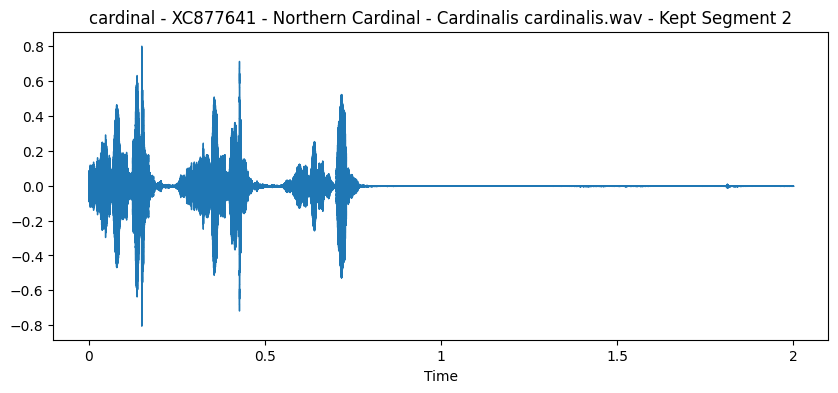

Playing rejected segment 1 of XC877641 - Northern Cardinal - Cardinalis cardinalis.wav from cardinal


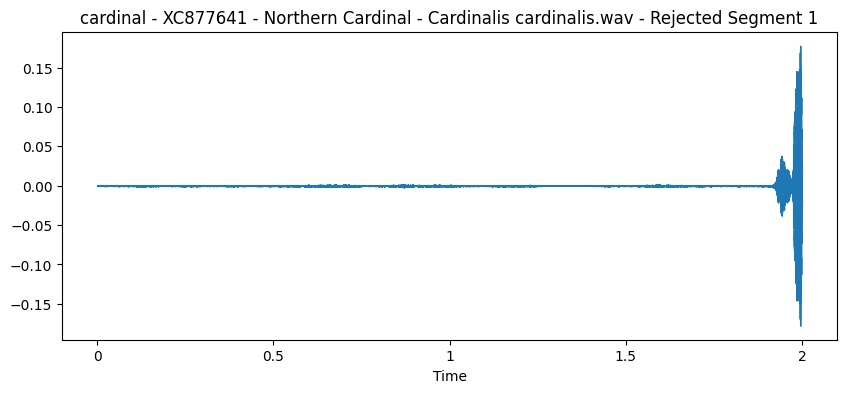

Playing rejected segment 2 of XC877641 - Northern Cardinal - Cardinalis cardinalis.wav from cardinal


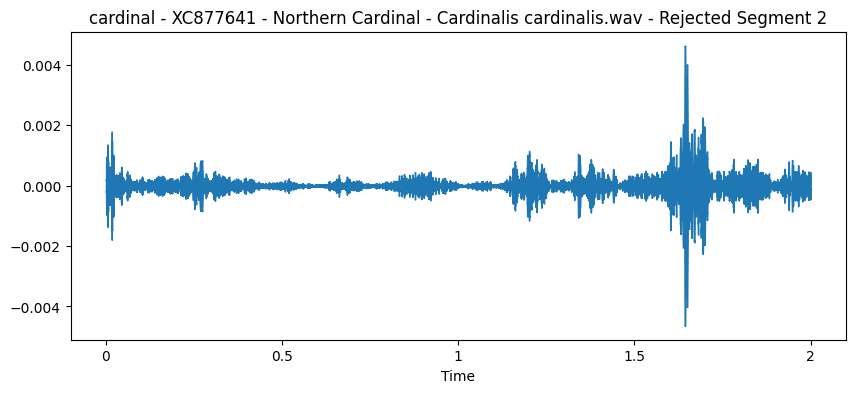

Shape of kept segment: (32000,)
Processing file: XC636507 - Red-bellied Woodpecker - Melanerpes carolinus.mp3 from red-bellied-woodpecker
Total segments: 11
Total kept segments: 7
Total rejected segments: 4
Playing kept segment 1 of XC636507 - Red-bellied Woodpecker - Melanerpes carolinus.mp3 from red-bellied-woodpecker


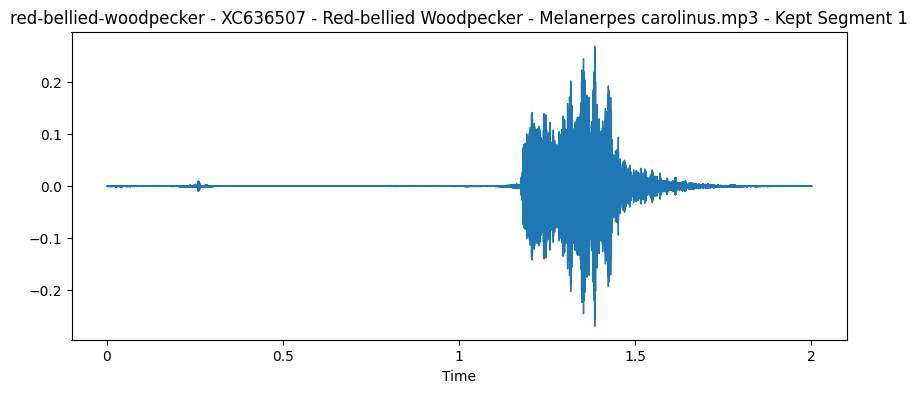

Playing kept segment 2 of XC636507 - Red-bellied Woodpecker - Melanerpes carolinus.mp3 from red-bellied-woodpecker


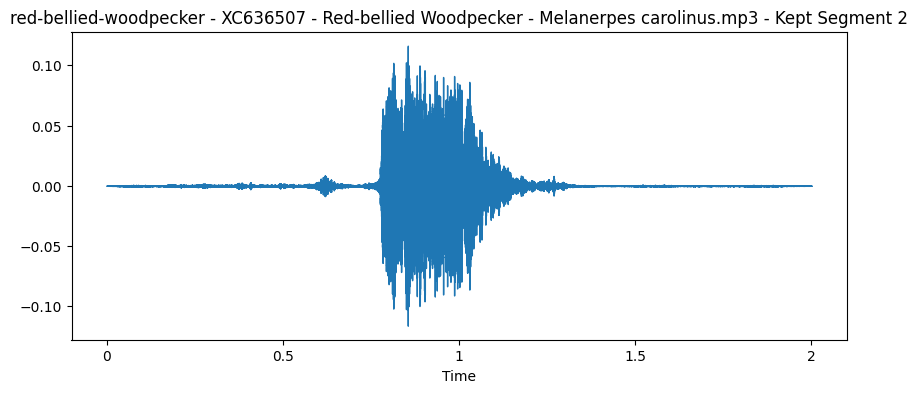

Playing rejected segment 1 of XC636507 - Red-bellied Woodpecker - Melanerpes carolinus.mp3 from red-bellied-woodpecker


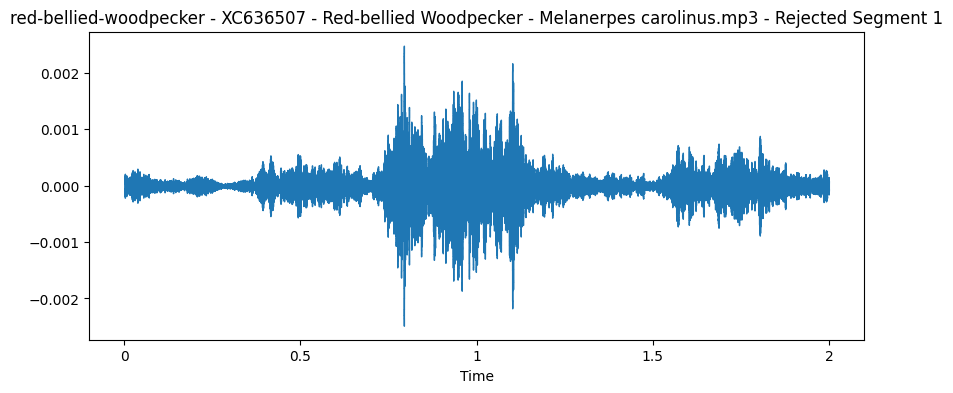

Playing rejected segment 2 of XC636507 - Red-bellied Woodpecker - Melanerpes carolinus.mp3 from red-bellied-woodpecker


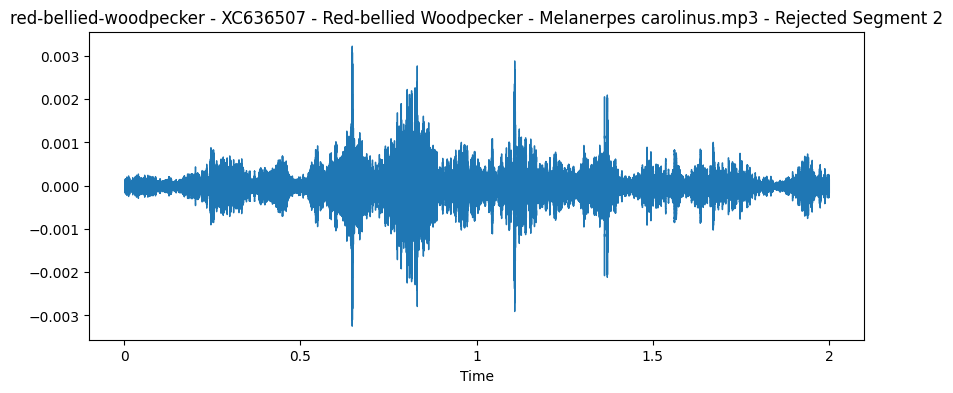

Shape of kept segment: (32000,)

Summary of Processed Files:
Species: blue-jay, File: XC545364.mp3
  Total Segments: 12
  Kept Segments: 2
  Removed Segments: 10
Species: cardinal, File: XC877641 - Northern Cardinal - Cardinalis cardinalis.wav
  Total Segments: 19
  Kept Segments: 9
  Removed Segments: 10
Species: red-bellied-woodpecker, File: XC636507 - Red-bellied Woodpecker - Melanerpes carolinus.mp3
  Total Segments: 11
  Kept Segments: 7
  Removed Segments: 4


In [3]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import noisereduce as nr
from IPython.display import Audio, display
from scipy.signal import butter, filtfilt

# Function to load audio files
def load_audio(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

# Function to apply high-pass filter
def high_pass_filter(y, sr, cutoff=100):
    nyquist = 0.5 * sr
    norm_cutoff = cutoff / nyquist
    b, a = butter(1, norm_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y)
    return y_filtered

# Function to segment audio into fixed lengths
def fixed_length_segments(y, sr, segment_length=2.0, energy_threshold=0.001):
    segment_samples = int(segment_length * sr)
    num_segments = int(np.ceil(len(y) / segment_samples))
    segments = []
    rejected_segments = []

    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        segment = y[start:end]
        if len(segment) < segment_samples:
            segment = np.pad(segment, (0, segment_samples - len(segment)), 'constant')

        # Compute energy of the segment
        energy = np.sum(segment ** 2) / len(segment)
        if energy > energy_threshold:
            segments.append(segment)
        else:
            rejected_segments.append(segment)

    return segments, rejected_segments

# Directory path
data_dir = 'data/raw/'

# Track files and their segments
processed_files = []

# Load and segment examples from each species
species = ['blue-jay', 'cardinal', 'red-bellied-woodpecker']
for bird in species:
    bird_dir = os.path.join(data_dir, bird)
    for file_name in os.listdir(bird_dir):
        if file_name.endswith('.mp3') or file_name.endswith('.wav'):
            file_path = os.path.join(bird_dir, file_name)
            y, sr = load_audio(file_path)

            # Calculate total segments before any transformation
            total_segments = int(np.ceil(len(y) / (2.0 * sr)))

            # Apply high-pass filter
            y_filtered = high_pass_filter(y, sr)

            # Reduce noise using noisereduce
            y_filtered = nr.reduce_noise(y=y_filtered, sr=sr, prop_decrease=1.0, stationary=True)

            # Original segments for rejection comparison
            segments, rejected_segments = fixed_length_segments(y_filtered, sr, segment_length=2.0, energy_threshold=0.0001)

            # Debugging statements
            print(f"Processing file: {file_name} from {bird}")
            print(f"Total segments: {total_segments}")
            print(f"Total kept segments: {len(segments)}")
            print(f"Total rejected segments: {len(rejected_segments)}")

            # Track file processing
            processed_files.append({
                'species': bird,
                'file_name': file_name,
                'total_segments': total_segments,
                'kept_segments': len(segments),
                'removed_segments': len(rejected_segments)
            })

            # Display the first two kept segments
            for i in range(min(2, len(segments))):
                print(f"Playing kept segment {i+1} of {file_name} from {bird}")
                display(Audio(data=segments[i], rate=sr))

                # Visualize the kept segment
                plt.figure(figsize=(10, 4))
                plt.title(f"{bird} - {file_name} - Kept Segment {i+1}")
                librosa.display.waveshow(segments[i], sr=sr)
                plt.show()

            # Display the first two rejected segments
            for i in range(min(2, len(rejected_segments))):
                print(f"Playing rejected segment {i+1} of {file_name} from {bird}")
                display(Audio(data=rejected_segments[i], rate=sr))

                # Visualize the rejected segment
                plt.figure(figsize=(10, 4))
                plt.title(f"{bird} - {file_name} - Rejected Segment {i+1}")
                librosa.display.waveshow(rejected_segments[i], sr=sr)
                plt.show()

            # Print the shape of the original segment
            if segments:
                print(f"Shape of kept segment: {segments[0].shape}")
            else:
                print(f"No segments with sufficient energy found for {file_name} from {bird}")
            break  # Just process one file per species for this example

# Display summary
print("\nSummary of Processed Files:")
for file_info in processed_files:
    print(f"Species: {file_info['species']}, File: {file_info['file_name']}")
    print(f"  Total Segments: {file_info['total_segments']}")
    print(f"  Kept Segments: {file_info['kept_segments']}")
    print(f"  Removed Segments: {file_info['removed_segments']}")

#### Explanation

1. **Loading Audio Files**:
    - We use the `librosa` library to load audio files. The function `load_audio` takes a file path and a sample rate (`sr`). The `librosa.load` function reads the audio file and resamples it to the specified sample rate (16,000 Hz in this case).
    - The output of this function is the audio time series (`y`) and the sample rate (`sr`).

2. **Segmenting Audio Files**:
    - **Segment Length**: We define a segment length of 2 seconds.
    - **Number of Segments**: The total number of segments is determined by dividing the total number of samples in the audio by the number of samples in each segment.
    - **Padding**: If the last segment is shorter than 2 seconds, we pad it with zeros to ensure uniform segment length.
    - **Visualizing Segments**: For each segment, we play the audio and visualize the waveform using `librosa.display.waveshow`.
    
    The shape of each audio segment before any transformation is a one-dimensional array with a length of 32,000 samples (since `16000 samples/second * 2 seconds = 32000 samples`).




# Step 3: Visualize and Analyze Audio Segments

In this step, we will visualize and analyze the processed audio segments to gain insights into their structure and characteristics. By plotting the waveform and amplitude distribution of the audio segments, we can better understand the data we are working with and ensure that the segmentation process has effectively captured the relevant features of the bird calls.

We will use the first segment from the kept segments to illustrate this process. The waveform plot will show the amplitude of the audio signal over time, while the amplitude distribution plot will highlight the frequency of different amplitude values within the segment. These visualizations will help us identify any anomalies or patterns in the audio data, ensuring that our segments are suitable for further processing and machine learning tasks.

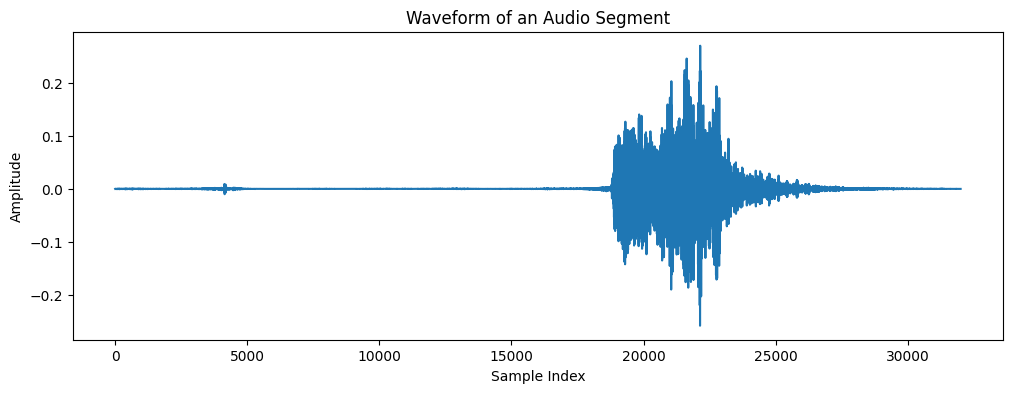

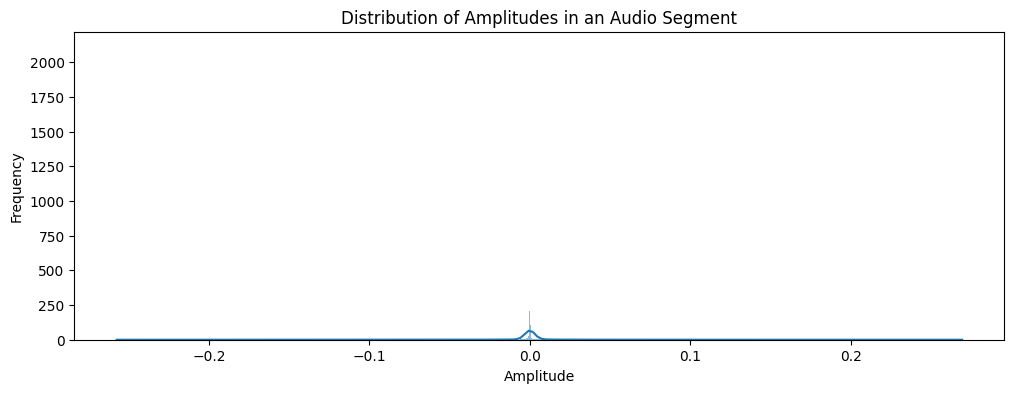

Shape of original segment: (32000,)


In [4]:


import seaborn as sns

# Selected Segment
segment = segments[0]

# Visualizing the shape of an audio segment
plt.figure(figsize=(12, 4))
plt.plot(segment)
plt.title('Waveform of an Audio Segment')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Visualizing the distribution of the audio segment's amplitudes
plt.figure(figsize=(12, 4))
sns.histplot(segment, kde=True)
plt.title('Distribution of Amplitudes in an Audio Segment')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()

# Display the shape of the segment
print(f"Shape of original segment: {segment.shape}")

#### Data Shape and Its Implications

- **Original Segment Shape**: `(32000,)`
    - This one-dimensional array represents the amplitude of the audio signal at each time step.
    - Each sample in the array corresponds to a fraction of a second of the audio signal.
    - This raw data is useful for basic audio analysis but may not be directly suitable for machine learning tasks due to its high dimensionality and lack of structured features.

- **Importance of Segmentation**:
    - Segmentation helps in breaking down long audio files into manageable pieces.
    - By analyzing these smaller segments, we can capture variations within the audio that might be lost in a longer, unsegmented file.
    - Segments ensure uniformity, making it easier to process and compare different parts of the audio.

The next step is to transform these raw audio segments into more structured forms like spectrograms and embeddings, which are more suitable for machine learning tasks. This involves extracting meaningful features that can help the model learn to differentiate between bird calls.

# Step 4: Generate Spectrograms

Spectrograms provide a visual representation of the spectrum of frequencies in a sound signal as it varies with time. They transform the audio signal into a time-frequency domain, making it easier to analyze and extract features relevant for machine learning tasks.

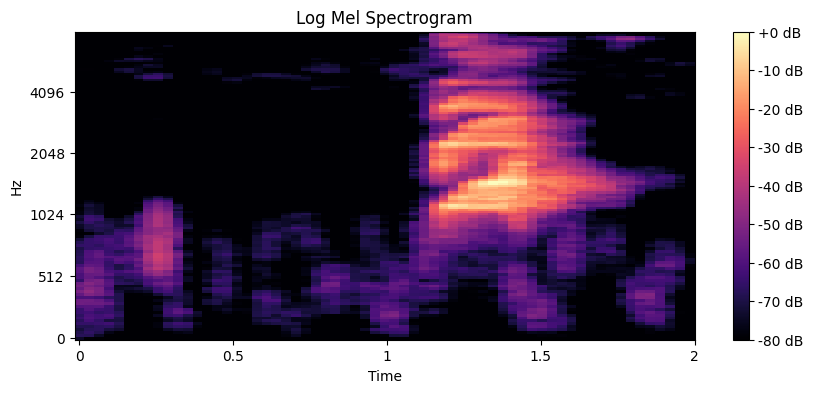

Shape of log mel spectrogram: (128, 63)


In [4]:
import librosa.display

# Function to compute log mel spectrogram
def compute_log_mel_spectrogram(segment, sr):
    S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# Compute and visualize log mel spectrogram for the first segment
if segments:
    log_mel_spectrogram = compute_log_mel_spectrogram(segments[0], sr)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel Spectrogram')
    plt.show()

    # Print the shape of the log mel spectrogram
    print("Shape of log mel spectrogram:", log_mel_spectrogram.shape)
else:
    print("No valid segments to process for log mel spectrogram.")


### Explanation:

#### 1. Compute Log Mel Spectrogram:

- We use the `librosa` library to compute the log mel spectrogram for an audio segment. The function `compute_log_mel_spectrogram` takes an audio segment and its sample rate as input and returns the log mel spectrogram.
- The mel spectrogram represents the short-term power spectrum of the audio signal, and the logarithmic scale is used to match human auditory perception.

#### 2. Visualize Log Mel Spectrogram:

- The log mel spectrogram is visualized using `librosa.display.specshow`. This provides a time-frequency representation of the audio segment, showing the intensity of different frequency components over time.

### Data Shape and Its Implications:

#### Log Mel Spectrogram Shape: `(128, 63)`

- The log mel spectrogram is a two-dimensional array representing the intensity of different frequency components over time.
- Each row corresponds to a mel frequency bin, and each column corresponds to a time frame. The number of time frames can vary based on the length of the segment and the parameters used for the spectrogram computation.
- This transformation reduces the dimensionality of the original audio segment while capturing meaningful features relevant for machine learning.

The next step is to transform these log mel spectrograms into embeddings using a pre-trained model like VGGish. Embeddings are compact representations of the audio signal that capture its essential features, making them suitable for downstream tasks such as classification.

# Step 5: Generate Embeddings Using VGGish

Embeddings are compact, fixed-size representations of data that capture the most relevant information. In the context of audio, embeddings capture the essential features of the sound signal, making them useful for tasks like classification. VGGish is a pre-trained model that generates embeddings from audio signals.

### First Code Snippit Generated the Used Embeddings




In [6]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Add the VGGish directory to the system path
sys.path.append('vggish')

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import vggish_slim
import vggish_params
import vggish_input
from vggish_postprocess import Postprocessor

# Function to load audio files
def load_audio(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

# Function to apply high-pass filter
def high_pass_filter(y, sr, cutoff=100):
    nyquist = 0.5 * sr
    norm_cutoff = cutoff / nyquist
    b, a = butter(1, norm_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y)
    return y_filtered

# Function to segment audio into fixed lengths
def fixed_length_segments(y, sr, segment_length=2.0, energy_threshold=0.001):
    segment_samples = int(segment_length * sr)
    num_segments = int(np.ceil(len(y) / segment_samples))
    segments = []
    rejected_segments = []

    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        segment = y[start:end]
        if len(segment) < segment_samples:
            segment = np.pad(segment, (0, segment_samples - len(segment)), 'constant')

        energy = np.sum(segment ** 2) / len(segment)
        if energy > energy_threshold:
            segments.append(segment)
        else:
            rejected_segments.append(segment)

    return segments, rejected_segments

# Function to create VGGish network
def CreateVGGishNetwork(hop_size=0.96):
    vggish_slim.define_vggish_slim()
    checkpoint_path = 'vggish/vggish_model.ckpt'
    vggish_params.EXAMPLE_HOP_SECONDS = hop_size
    vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)
    features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)
    return {'features': features_tensor, 'embedding': embedding_tensor}

# Function to process with VGGish
def ProcessWithVGGish(vgg, x):
    input_batch = np.array(x)
    [embedding_batch] = sess.run([vgg['embedding']], feed_dict={vgg['features']: input_batch})
    pca_params_path = 'vggish/vggish_pca_params.npz'
    pproc = Postprocessor(pca_params_path)
    postprocessed_batch = pproc.postprocess(embedding_batch)
    return postprocessed_batch

# Clear the embeddings directory
embeddings_dir = 'data/embeddings/'
if os.path.exists(embeddings_dir):
    shutil.rmtree(embeddings_dir)
os.makedirs(embeddings_dir, exist_ok=True)

# Step 1: Load and Preprocess Audio Files
data_dir = 'data/raw/'
kept_dir = 'data/kept/'
os.makedirs(kept_dir, exist_ok=True)

species = ['blue-jay', 'cardinal', 'red-bellied-woodpecker']

# Set Up TensorFlow Session
tf.reset_default_graph()
sess = tf.Session()
vgg = CreateVGGishNetwork()

embedding_counts = {bird: 0 for bird in species}
processed_files = []

for bird in species:
    bird_dir = os.path.join(data_dir, bird)
    kept_bird_dir = os.path.join(kept_dir, bird)
    embeddings_bird_dir = os.path.join(embeddings_dir, bird, 'spectrogram')
    os.makedirs(kept_bird_dir, exist_ok=True)
    os.makedirs(embeddings_bird_dir, exist_ok=True)

    for file_name in os.listdir(bird_dir):
        if file_name.endswith('.mp3') or file_name.endswith('.wav'):
            file_path = os.path.join(bird_dir, file_name)
            y, sr = load_audio(file_path)
            total_segments = int(np.ceil(len(y) / (2.0 * sr)))
            y_filtered = high_pass_filter(y, sr)
            y_filtered = nr.reduce_noise(y=y_filtered, sr=sr, prop_decrease=1.0, stationary=True)
            segments, rejected_segments = fixed_length_segments(y_filtered, sr, segment_length=2.0, energy_threshold=0.0001)
            processed_files.append({
                'species': bird,
                'file_name': file_name,
                'total_segments': total_segments,
                'kept_segments': len(segments),
                'removed_segments': len(rejected_segments)
            })

            print(f"Processing file: {file_name} from {bird}")
            print(f"Total segments: {total_segments}")
            print(f"Kept segments: {len(segments)}")
            print(f"Rejected segments: {len(rejected_segments)}")

            # Display kept and rejected segments
            if segments:
                print(f"Kept segment shape: {segments[0].shape}")

            if rejected_segments:
                print(f"Rejected segment shape: {rejected_segments[0].shape}")

            for i, segment in enumerate(segments):
                segment_file_path = os.path.join(kept_bird_dir, f"{os.path.splitext(file_name)[0]}_segment_{i+1}.wav")
                sf.write(segment_file_path, segment, sr)

                log_mel = vggish_input.waveform_to_examples(segment, sr)
                spectrogram_embedding = ProcessWithVGGish(vgg, log_mel)
                segment_embedding_path = os.path.join(embeddings_bird_dir, f"{os.path.splitext(file_name)[0]}_segment_{i+1}.npy")
                np.save(segment_embedding_path, spectrogram_embedding)
                embedding_counts[bird] += 1

print("\nSummary of Processed Files:")
for file_info in processed_files:
    print(f"Species: {file_info['species']}, File: {file_info['file_name']}")
    print(f"  Total Segments: {file_info['total_segments']}")
    print(f"  Kept Segments: {file_info['kept_segments']}")
    print(f"  Removed Segments: {file_info['removed_segments']}")

print("\nSummary of Generated Embeddings:")
for bird, count in embedding_counts.items():
    print(f"Species: {bird}, Embeddings Generated: {count}")

Instructions for updating:
non-resource variables are not supported in the long term
/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


Processing file: XC545364.mp3 from blue-jay
Total segments: 12
Kept segments: 2
Rejected segments: 10
Kept segment shape: (32000,)
Rejected segment shape: (32000,)
Processing file: XC545363.mp3 from blue-jay
Total segments: 4
Kept segments: 2
Rejected segments: 2
Kept segment shape: (32000,)
Rejected segment shape: (32000,)
Processing file: XC899923.mp3 from blue-jay
Total segments: 5
Kept segments: 2
Rejected segments: 3
Kept segment shape: (32000,)
Rejected segment shape: (32000,)
Processing file: XC721247.mp3 from blue-jay
Total segments: 20
Kept segments: 13
Rejected segments: 7
Kept segment shape: (32000,)
Rejected segment shape: (32000,)
Processing file: XC696438.mp3 from blue-jay
Total segments: 5
Kept segments: 3
Rejected segments: 2
Kept segment shape: (32000,)
Rejected segment shape: (32000,)
Processing file: XC636535.mp3 from blue-jay
Total segments: 13
Kept segments: 12
Rejected segments: 1
Kept segment shape: (32000,)
Rejected segment shape: (32000,)
Processing file: XC908

### Second Code Snippit Allows Loading Previously Generated Embeddings

In [5]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import json

# Add the VGGish directory to the system path
sys.path.append('vggish')

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import vggish_slim
import vggish_params
import vggish_input
from vggish_postprocess import Postprocessor

# Function to load audio files
def load_audio(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

# Function to apply high-pass filter
def high_pass_filter(y, sr, cutoff=100):
    nyquist = 0.5 * sr
    norm_cutoff = cutoff / nyquist
    b, a = butter(1, norm_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y)
    return y_filtered

# Function to segment audio into fixed lengths
def fixed_length_segments(y, sr, segment_length=2.0, energy_threshold=0.001):
    segment_samples = int(segment_length * sr)
    num_segments = int(np.ceil(len(y) / segment_samples))
    segments = []
    rejected_segments = []

    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        segment = y[start:end]
        if len(segment) < segment_samples:
            segment = np.pad(segment, (0, segment_samples - len(segment)), 'constant')

        energy = np.sum(segment ** 2) / len(segment)
        if energy > energy_threshold:
            segments.append(segment)
        else:
            rejected_segments.append(segment)

    return segments, rejected_segments

# Function to create VGGish network
def CreateVGGishNetwork(hop_size=0.96):
    vggish_slim.define_vggish_slim()
    checkpoint_path = 'vggish/vggish_model.ckpt'
    vggish_params.EXAMPLE_HOP_SECONDS = hop_size
    vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)
    features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)
    return {'features': features_tensor, 'embedding': embedding_tensor}

# Function to process with VGGish
def ProcessWithVGGish(vgg, x):
    input_batch = np.array(x)
    [embedding_batch] = sess.run([vgg['embedding']], feed_dict={vgg['features']: input_batch})
    pca_params_path = 'vggish/vggish_pca_params.npz'
    pproc = Postprocessor(pca_params_path)
    postprocessed_batch = pproc.postprocess(embedding_batch)
    return postprocessed_batch

# Define directories
embeddings_dir = 'data/embeddings/'
metadata_file = 'data/metadata.json'
force_process = False  # Set this flag to True to force processing every time

# Check if embeddings and metadata exist
if os.path.exists(embeddings_dir) and os.path.exists(metadata_file) and not force_process:
    print("Loading existing embeddings and metadata...")
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
else:
    print("Processing and saving embeddings and metadata...")

    # Clear the embeddings directory
    if os.path.exists(embeddings_dir):
        shutil.rmtree(embeddings_dir)
    os.makedirs(embeddings_dir, exist_ok=True)

    # Step 1: Load and Preprocess Audio Files
    data_dir = 'data/raw/'
    kept_dir = 'data/kept/'
    os.makedirs(kept_dir, exist_ok=True)

    species = ['blue-jay', 'cardinal', 'red-bellied-woodpecker']

    # Set Up TensorFlow Session
    tf.reset_default_graph()
    sess = tf.Session()
    vgg = CreateVGGishNetwork()

    embedding_counts = {bird: 0 for bird in species}
    processed_files = []

    for bird in species:
        bird_dir = os.path.join(data_dir, bird)
        kept_bird_dir = os.path.join(kept_dir, bird)
        embeddings_bird_dir = os.path.join(embeddings_dir, bird, 'spectrogram')
        os.makedirs(kept_bird_dir, exist_ok=True)
        os.makedirs(embeddings_bird_dir, exist_ok=True)

        for file_name in os.listdir(bird_dir):
            if file_name.endswith('.mp3') or file_name.endswith('.wav'):
                file_path = os.path.join(bird_dir, file_name)
                y, sr = load_audio(file_path)
                total_segments = int(np.ceil(len(y) / (2.0 * sr)))
                y_filtered = high_pass_filter(y, sr)
                y_filtered = nr.reduce_noise(y=y_filtered, sr=sr, prop_decrease=1.0, stationary=True)
                segments, rejected_segments = fixed_length_segments(y_filtered, sr, segment_length=2.0, energy_threshold=0.0001)
                processed_files.append({
                    'species': bird,
                    'file_name': file_name,
                    'total_segments': total_segments,
                    'kept_segments': len(segments),
                    'removed_segments': len(rejected_segments)
                })

                print(f"Processing file: {file_name} from {bird}")
                print(f"Total segments: {total_segments}")
                print(f"Kept segments: {len(segments)}")
                print(f"Rejected segments: {len(rejected_segments)}")

                for i, segment in enumerate(segments):
                    segment_file_path = os.path.join(kept_bird_dir, f"{os.path.splitext(file_name)[0]}_segment_{i+1}.wav")
                    sf.write(segment_file_path, segment, sr)

                    log_mel = vggish_input.waveform_to_examples(segment, sr)
                    spectrogram_embedding = ProcessWithVGGish(vgg, log_mel)
                    segment_embedding_path = os.path.join(embeddings_bird_dir, f"{os.path.splitext(file_name)[0]}_segment_{i+1}.npy")
                    np.save(segment_embedding_path, spectrogram_embedding)
                    embedding_counts[bird] += 1

    # Save metadata
    metadata = {
        'processed_files': processed_files,
        'embedding_counts': embedding_counts
    }

    with open(metadata_file, 'w') as f:
        json.dump(metadata, f)

    print("\nSummary of Processed Files:")
    for file_info in processed_files:
        print(f"Species: {file_info['species']}, File: {file_info['file_name']}")
        print(f"  Total Segments: {file_info['total_segments']}")
        print(f"  Kept Segments: {file_info['kept_segments']}")
        print(f"  Removed Segments: {file_info['removed_segments']}")

    print("\nSummary of Generated Embeddings:")
    for bird, count in embedding_counts.items():
        print(f"Species: {bird}, Embeddings Generated: {count}")


Instructions for updating:
non-resource variables are not supported in the long term


Loading existing embeddings and metadata...


### Explanation:

#### 1. Create VGGish Network:

- We define the VGGish model and load the pre-trained checkpoint. The function `CreateVGGishNetwork` sets up the VGGish model and returns a dictionary pointing to the input and output tensors.

#### 2. Process with VGGish:

- The function `ProcessWithVGGish` runs the VGGish model on a log mel spectrogram and returns the post-processed embeddings. The embeddings are compact representations of the audio signal, capturing its essential features.

#### 3. Generate and Save Embeddings:

- For each audio segment, we generate log mel spectrograms and process them with VGGish to obtain embeddings. The embeddings are saved as `.npy` files for later use.

### Data Shape and Its Implications:

#### Original Segment Shape: `(32000,)`

- The original audio segment is a one-dimensional array representing the amplitude of the audio signal at each time step.
- Each sample corresponds to a fraction of a second of the audio signal.

#### Log Mel Spectrogram Shape: `(128, 63)`

- The log mel spectrogram is a two-dimensional array representing the intensity of different frequency components over time.
- This transformation captures the frequency content of the audio signal, providing a time-frequency representation.

#### Embedding Shape: `(2, 128)`

- The embeddings are compact, fixed-size representations of the audio signal.
- They capture the most relevant information, making them suitable for machine learning tasks such as classification.

Embeddings are particularly useful because they reduce the dimensionality of the data while preserving its essential features. This makes it easier to train and evaluate machine learning models.

# Step 6: Compute Summary Statistics and Visualize Embeddings

In this section, we will analyze the embeddings by computing summary statistics and visualizing the data. This will help us understand how well the embeddings capture the distinguishing features of the bird calls. We will also employ Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings and visualize them in a two-dimensional space.

First, we will load the embeddings for each bird species and compute summary statistics to gain insights into the data distribution. Next, we will apply PCA to visualize the embeddings in a lower-dimensional space, which will help us observe the clustering behavior of the different bird species. Additionally, we will visualize the embedding values for a single segment and compute the average embeddings by species to see the overall patterns.



Summary Statistics for Blue-jay Embeddings:
              0           1           2           3           4           5    \
count  626.000000  626.000000  626.000000  626.000000  626.000000  626.000000   
mean   115.769968   47.421725  133.242812   99.872204   98.346645  105.872204   
std     21.162717   17.147392   14.553905   27.709804   31.479969   27.191168   
min     42.000000   13.000000   60.000000    0.000000   11.000000   33.000000   
25%    102.000000   36.000000  124.000000   88.250000   78.000000   89.000000   
50%    116.000000   44.000000  134.000000  104.000000   96.000000  104.000000   
75%    129.000000   56.000000  143.000000  118.000000  117.000000  120.000000   
max    177.000000  123.000000  200.000000  162.000000  195.000000  253.000000   

              6           7           8           9    ...         118  \
count  626.000000  626.000000  626.000000  626.000000  ...  626.000000   
mean    62.603834  115.878594  211.079872  159.726837  ...  171.811502   
std

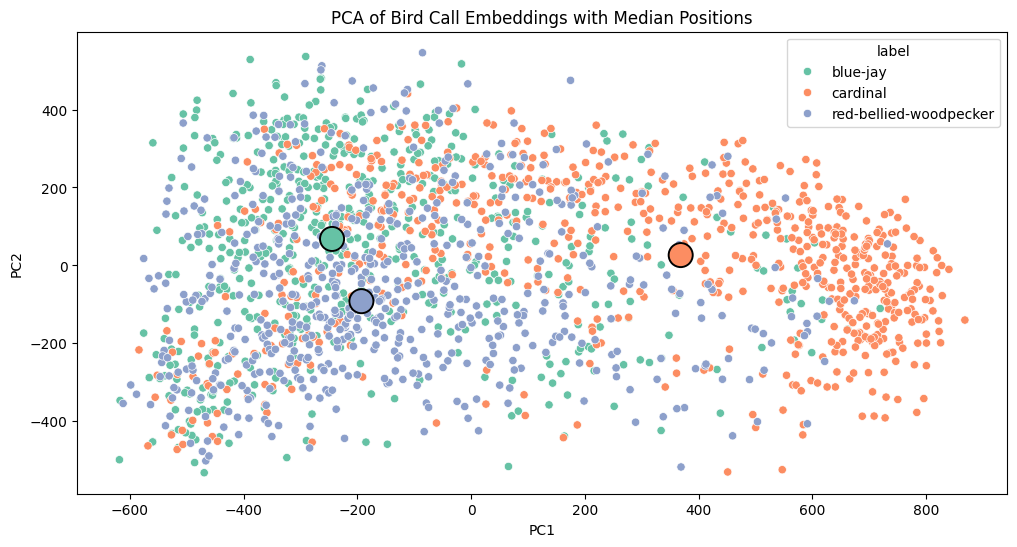

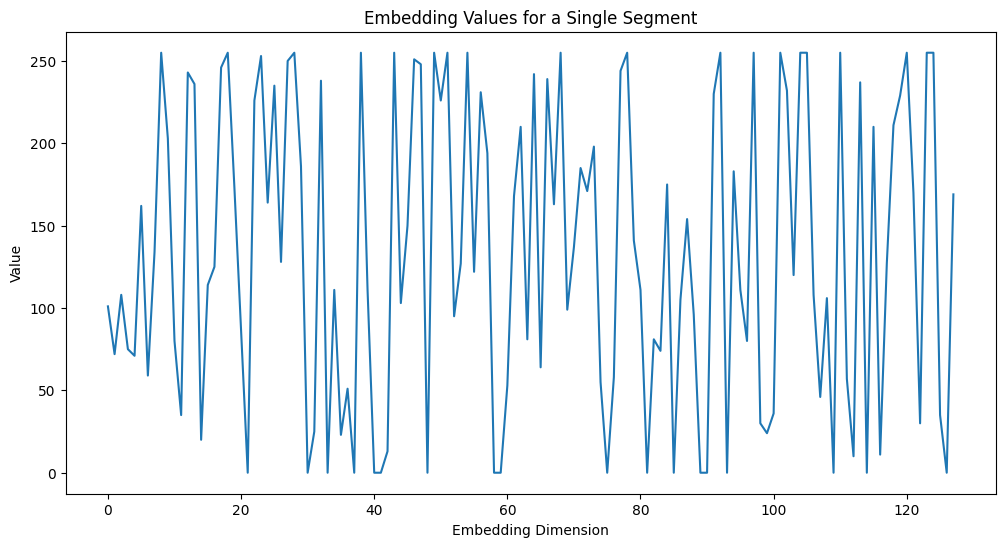

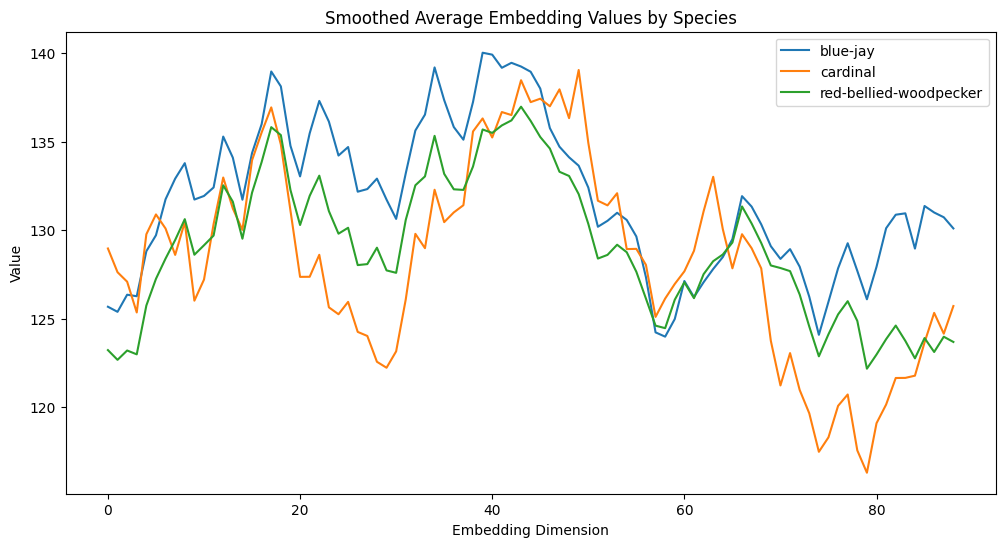

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Smoothing function using a moving average
def moving_average(data, window_size=7):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Load embeddings and compute summary statistics
embedding_files = []
labels = []

for bird in species:
    embeddings_bird_dir = os.path.join(embeddings_dir, bird, 'spectrogram')
    for file_name in os.listdir(embeddings_bird_dir):
        file_path = os.path.join(embeddings_bird_dir, file_name)
        embeddings = np.load(file_path)
        embedding_files.append(embeddings)
        labels.extend([bird] * embeddings.shape[0])  # Add correct number of labels

# Convert embeddings to DataFrame
embeddings = np.concatenate(embedding_files, axis=0)
df_embeddings = pd.DataFrame(embeddings)

# Detailed Summary Statistics by Species
for bird in species:
    bird_embeddings = df_embeddings[np.array(labels) == bird]
    print(f"\nSummary Statistics for {bird.capitalize()} Embeddings:")
    print(bird_embeddings.describe())

# Overall Summary Statistics
summary_stats = df_embeddings.describe()
print("\nOverall Summary Statistics for Embeddings:")
print(summary_stats)

# PCA Plot
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_embeddings)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Debugging statements
print(f"Number of embeddings: {df_embeddings.shape[0]}")
print(f"Number of labels: {len(labels)}")

# Ensure the number of labels matches the number of embeddings
assert len(labels) == pca_df.shape[0], f"Length of labels ({len(labels)}) does not match length of embeddings ({pca_df.shape[0]})"

pca_df['label'] = labels

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette='Set2')
median_pca_positions = pca_df.groupby('label').median().reset_index()
sns.scatterplot(x='PC1', y='PC2', hue='label', data=median_pca_positions, palette='Set2', s=300, legend=False, marker='o', edgecolor='black')  # Increase size by 1.5 times
plt.title('PCA of Bird Call Embeddings with Median Positions')
plt.show()

# Visualize a single segment's embeddings
single_embedding = df_embeddings.iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(single_embedding.values)
plt.title('Embedding Values for a Single Segment')
plt.xlabel('Embedding Dimension')
plt.ylabel('Value')
plt.show()

# Compute and visualize aggregate average embeddings by species
average_embeddings = {}
for bird in species:
    bird_embeddings = []
    embeddings_bird_dir = os.path.join(embeddings_dir, bird, 'spectrogram')
    for file_name in os.listdir(embeddings_bird_dir):
        file_path = os.path.join(embeddings_bird_dir, file_name)
        embeddings = np.load(file_path)
        bird_embeddings.append(embeddings)
    bird_embeddings = np.concatenate(bird_embeddings, axis=0)
    average_embeddings[bird] = np.mean(bird_embeddings, axis=0)

plt.figure(figsize=(12, 6))
for bird, avg_embedding in average_embeddings.items():
    smooth_embedding = moving_average(avg_embedding, window_size=40)  # Adjust window size as needed
    plt.plot(smooth_embedding, label=bird)
plt.title('Smoothed Average Embedding Values by Species')
plt.xlabel('Embedding Dimension')
plt.ylabel('Value')
plt.legend()
plt.show()


# Step 7: Train and Evaluate Classification Models

In this step, we will train various machine learning models to classify bird species based on their call embeddings. We will include traditional machine learning models, neural networks, and convolutional neural networks (CNNs). The evaluation of these models will be done using metrics such as accuracy, precision, recall, and F1-score.

## Training & Testing Split

We will split our data into training and testing sets, train the models, and evaluate their performance. This comprehensive approach ensures that we assess the effectiveness of different model architectures and identify the best-performing model for bird call classification.



In [12]:
# Train and Evaluate Classification Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Ensure the correct number of labels
labels = []
for bird in species:
    embeddings_bird_dir = os.path.join(embeddings_dir, bird, 'spectrogram')
    for file_name in os.listdir(embeddings_bird_dir):
        file_path = os.path.join(embeddings_bird_dir, file_name)
        embeddings = np.load(file_path)
        labels.extend([bird] * embeddings.shape[0])  # Add correct number of labels

# Check if the number of embeddings matches the number of labels
assert df_embeddings.shape[0] == len(labels), "Mismatch between number of embeddings and labels"

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_embeddings, labels, test_size=0.2, random_state=42)

# Print summary statistics for training and testing sets
train_labels_df = pd.DataFrame(y_train, columns=['species'])
test_labels_df = pd.DataFrame(y_test, columns=['species'])

print("\nTraining Set Summary:")
print(train_labels_df['species'].value_counts())
print(f"Training set shape: {X_train.shape}")

print("\nTesting Set Summary:")
print(test_labels_df['species'].value_counts())
print(f"Testing set shape: {X_test.shape}")



Training Set Summary:
species
cardinal                  576
red-bellied-woodpecker    501
blue-jay                  489
Name: count, dtype: int64
Training set shape: (1566, 128)

Testing Set Summary:
species
blue-jay                  137
cardinal                  128
red-bellied-woodpecker    127
Name: count, dtype: int64
Testing set shape: (392, 128)


# Step 7.1: Supervised Machine Learning Models

To begin, we will train and evaluate traditional machine learning models, including Random Forest and Support Vector Machine (SVM) classifiers, as well as a basic Neural Network.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Random Forest Classifier Report:
                        precision    recall  f1-score   support

              blue-jay       0.75      0.77      0.76       137
              cardinal       0.87      0.84      0.85       128
red-bellied-woodpecker       0.75      0.76      0.76       127

              accuracy                           0.79       392
             macro avg       0.79      0.79      0.79       392
          weighted avg       0.79      0.79      0.79       392

Accuracy: 0.7882653061224489

Neural Network Classifier Report:
                        precision    recall  f1-score   support

              blue-jay       0.68      0.70      0.69       137
              cardinal       0.85      0.85      0.85       128
red-bellied-woodpecker       0.72      0.69      0.70       127

              accuracy                           0.75       392
             macro avg       0.75      0.75      0.75       392
          weighted avg       0.75      0.75      0.75       392



<ipython-input-15-ca8629265d9f>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='Set2')


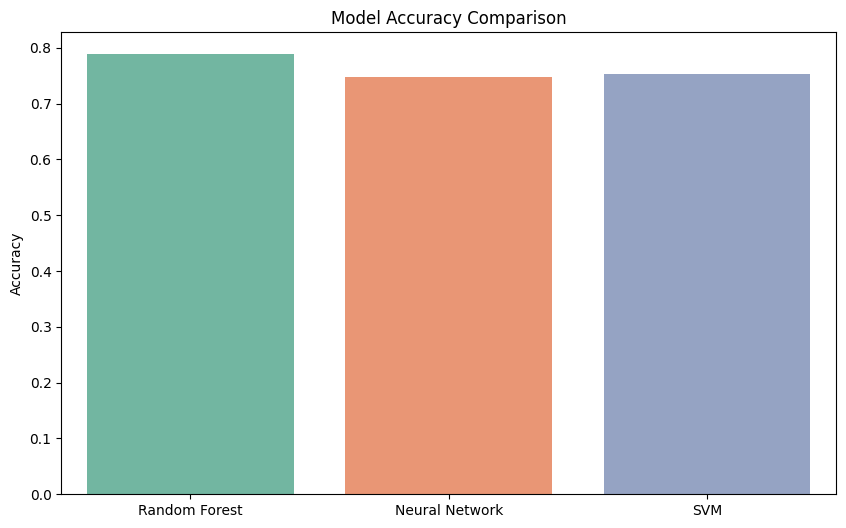

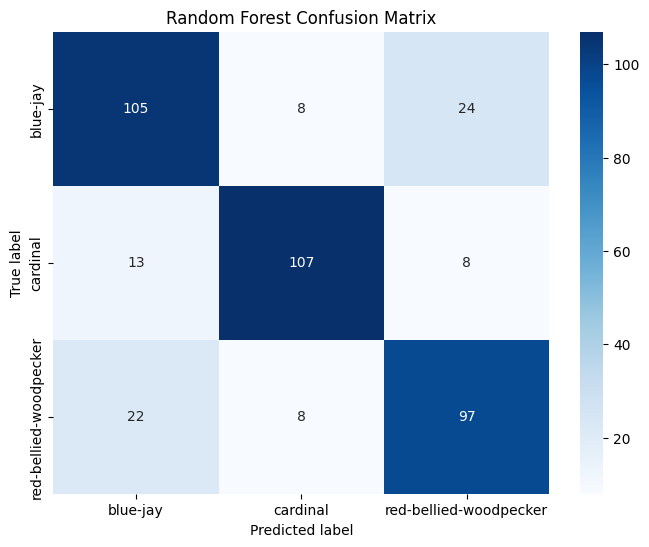

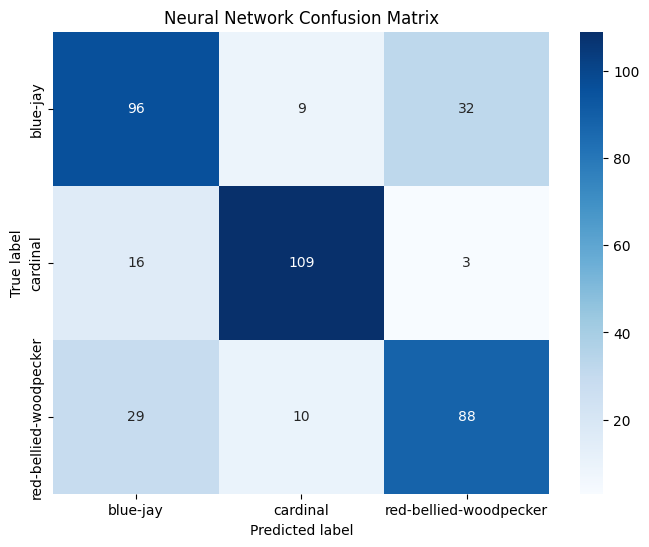

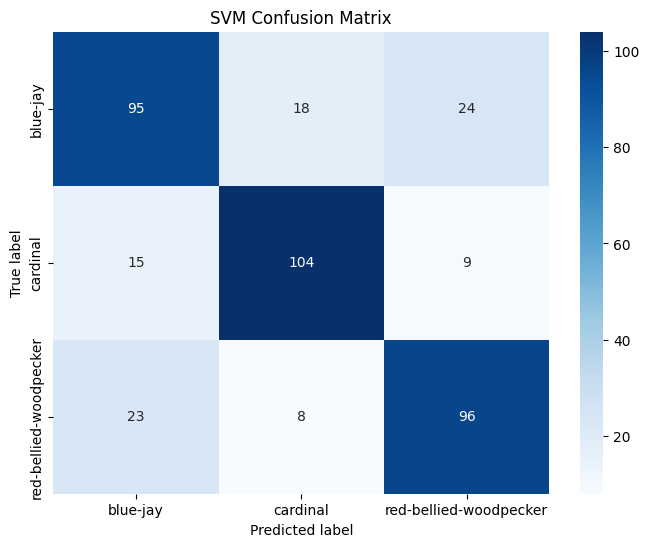

Random Forest - Precision: 0.79, Recall: 0.79, F1 Score: 0.79
Neural Network - Precision: 0.75, Recall: 0.75, F1 Score: 0.75
SVM - Precision: 0.75, Recall: 0.75, F1 Score: 0.75


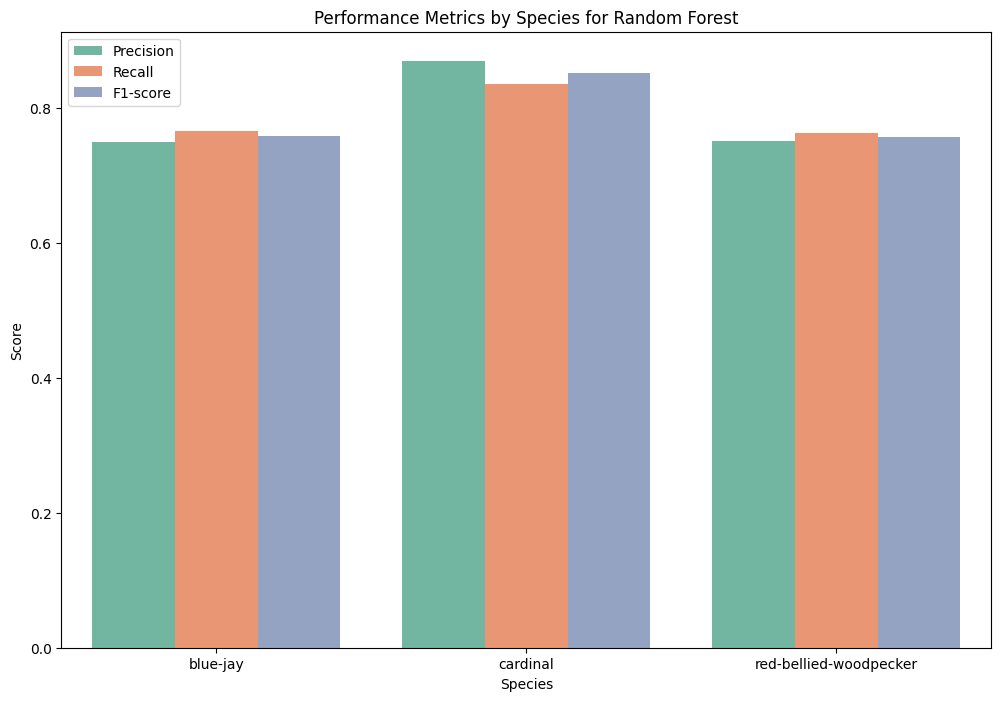

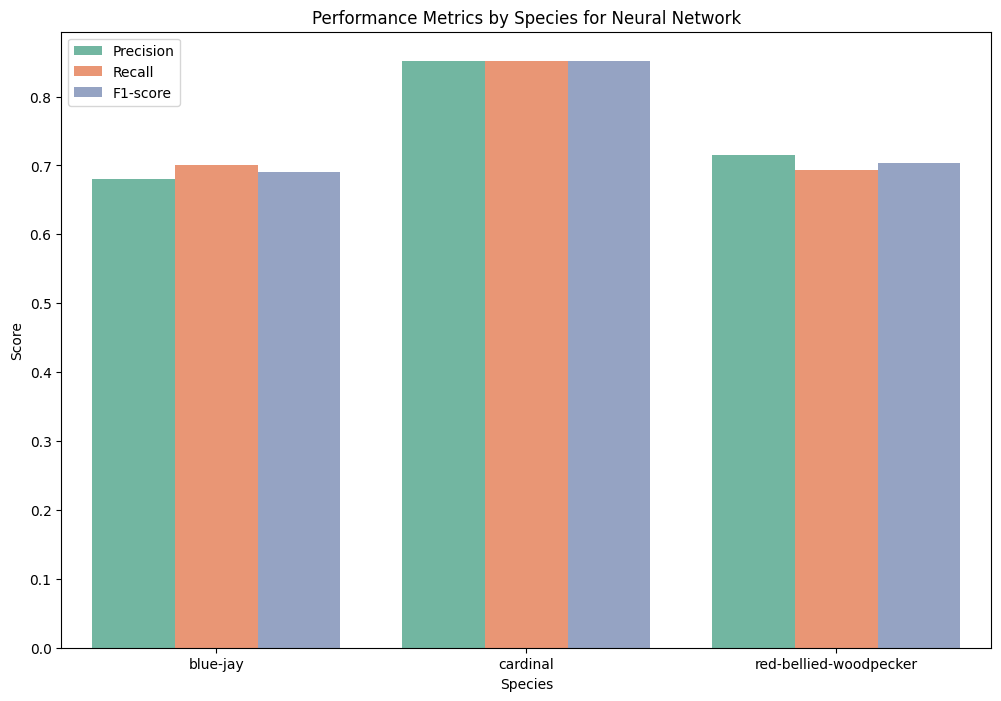

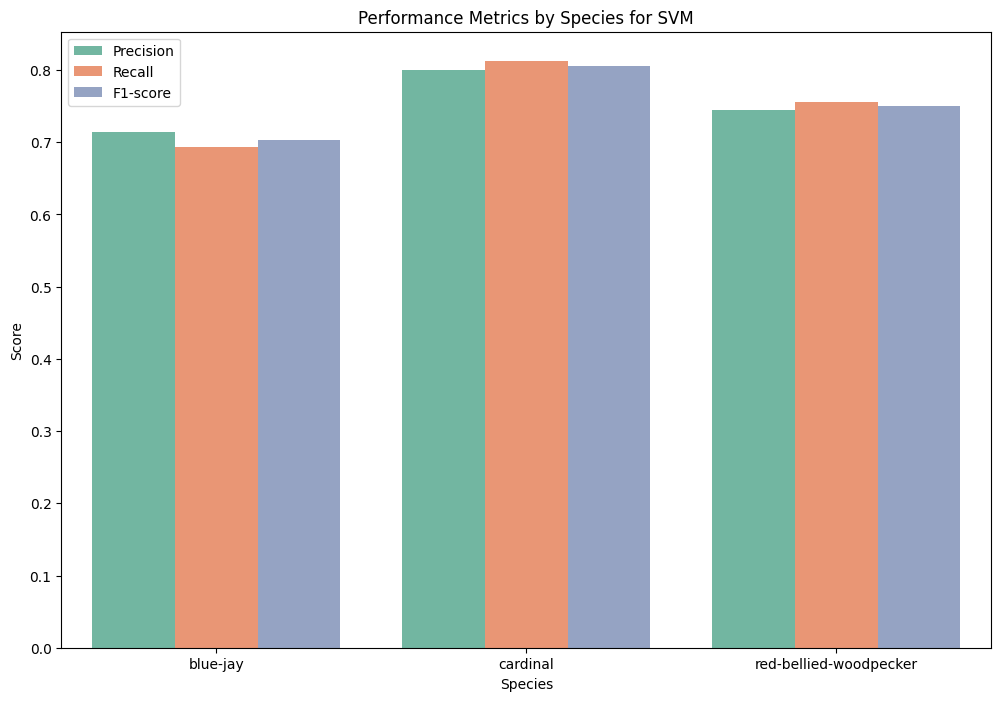

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Define the neural network model
def create_nn_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')  # 3 classes for blue-jay, cardinal, and red-bellied-woodpecker
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# One-hot encode the labels for neural network
label_map = {bird: i for i, bird in enumerate(species)}
y_train_encoded = np.array([label_map[label] for label in y_train])
y_test_encoded = np.array([label_map[label] for label in y_test])

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions, output_dict=True)

# Train Neural Network Classifier
nn_model = create_nn_model(X_train.shape[1])
nn_model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, verbose=0)
nn_predictions = np.argmax(nn_model.predict(X_test), axis=1)
nn_accuracy = accuracy_score(y_test_encoded, nn_predictions)
nn_report = classification_report(y_test_encoded, nn_predictions, target_names=species, output_dict=True)

# Train SVM Classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_report = classification_report(y_test, svm_predictions, output_dict=True)

# Print reports
print("\nRandom Forest Classifier Report:")
print(classification_report(y_test, rf_predictions))
print("Accuracy:", rf_accuracy)

print("\nNeural Network Classifier Report:")
print(classification_report(y_test_encoded, nn_predictions, target_names=species))
print("Accuracy:", nn_accuracy)

print("\nSVM Classifier Report:")
print(classification_report(y_test, svm_predictions))
print("Accuracy:", svm_accuracy)

# Visualize model performance
models = ['Random Forest', 'Neural Network', 'SVM']
accuracies = [rf_accuracy, nn_accuracy, svm_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='Set2')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

# Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Confusion matrices
rf_cm = confusion_matrix(y_test, rf_predictions)
nn_cm = confusion_matrix(y_test_encoded, nn_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)

plot_confusion_matrix(rf_cm, species, title='Random Forest Confusion Matrix')
plot_confusion_matrix(nn_cm, species, title='Neural Network Confusion Matrix')
plot_confusion_matrix(svm_cm, species, title='SVM Confusion Matrix')

# Additional performance stats
def print_additional_stats(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

print_additional_stats(y_test, rf_predictions, "Random Forest")
print_additional_stats(y_test_encoded, nn_predictions, "Neural Network")
print_additional_stats(y_test, svm_predictions, "SVM")

# Performance bar plot by species
def performance_by_species(report, species):
    metrics = ['precision', 'recall', 'f1-score']
    performance_data = []

    for bird in species:
        for metric in metrics:
            performance_data.append({
                'Species': bird,
                'Metric': metric.capitalize(),
                'Score': report[bird][metric]
            })

    return pd.DataFrame(performance_data)

rf_performance_df = performance_by_species(rf_report, species)
nn_performance_df = performance_by_species(nn_report, species)
svm_performance_df = performance_by_species(svm_report, species)

# Plot performance bar plot by species
def plot_performance_by_species(performance_df, model_name):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Species', y='Score', hue='Metric', data=performance_df, palette='Set2')
    plt.title(f'Performance Metrics by Species for {model_name}')
    plt.ylabel('Score')
    plt.legend(loc='upper left')
    plt.show()

plot_performance_by_species(rf_performance_df, 'Random Forest')
plot_performance_by_species(nn_performance_df, 'Neural Network')
plot_performance_by_species(svm_performance_df, 'SVM')


# Step 7.2: Advanced Neural Network Models

We will now train more advanced neural network models, including Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks. These models can capture temporal dependencies and spatial features in the bird call embeddings.

Train on 1566 samples
Epoch 1/1000
1566/1566 [==============================] - 1s 576us/sample - loss: 7.2892 - acc: 0.4119
Epoch 2/1000
1566/1566 [==============================] - 0s 83us/sample - loss: 1.0136 - acc: 0.4432
Epoch 3/1000
1566/1566 [==============================] - 0s 77us/sample - loss: 0.9687 - acc: 0.4885
Epoch 4/1000
1566/1566 [==============================] - 0s 76us/sample - loss: 0.9176 - acc: 0.5262
Epoch 5/1000
1566/1566 [==============================] - 0s 75us/sample - loss: 0.9224 - acc: 0.5364
Epoch 6/1000
1566/1566 [==============================] - 0s 75us/sample - loss: 0.8861 - acc: 0.5811
Epoch 7/1000
1566/1566 [==============================] - 0s 73us/sample - loss: 0.8388 - acc: 0.6054
Epoch 8/1000
1566/1566 [==============================] - 0s 74us/sample - loss: 0.8202 - acc: 0.6232
Epoch 9/1000
1566/1566 [==============================] - 0s 72us/sample - loss: 0.8166 - acc: 0.6188
Epoch 10/1000
1566/1566 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 1566 samples
Epoch 1/30
1566/1566 [==============================] - 1s 411us/sample - loss: 0.9929 - acc: 0.5013
Epoch 2/30
1566/1566 [==============================] - 0s 107us/sample - loss: 0.9066 - acc: 0.5690
Epoch 3/30
1566/1566 [==============================] - 0s 108us/sample - loss: 0.9056 - acc: 0.5760
Epoch 4/30
1566/1566 [==============================] - 0s 116us/sample - loss: 0.8757 - acc: 0.5792
Epoch 5/30
1566/1566 [==============================] - 0s 114us/sample - loss: 0.8764 - acc: 0.5587
Epoch 6/30
1566/1566 [==============================] - 0s 110us/sample - loss: 0.8882 - acc: 0.5613
Epoch 7/30
1566/1566 [==============================] - 0s 111us/sample - loss: 0.9255 - acc: 0.5402
Epoch 8/30
1566/1566 [==============================] - 0s 114us/sample - loss: 0.9047 - acc: 0.5658
Epoch 9/30
1566/1566 [==============================] - 0s 110us/sample - loss: 0.8660 - acc: 0.5792
Epoch 10/30
1566/1566 [==============================] - 0s 106us/sam

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


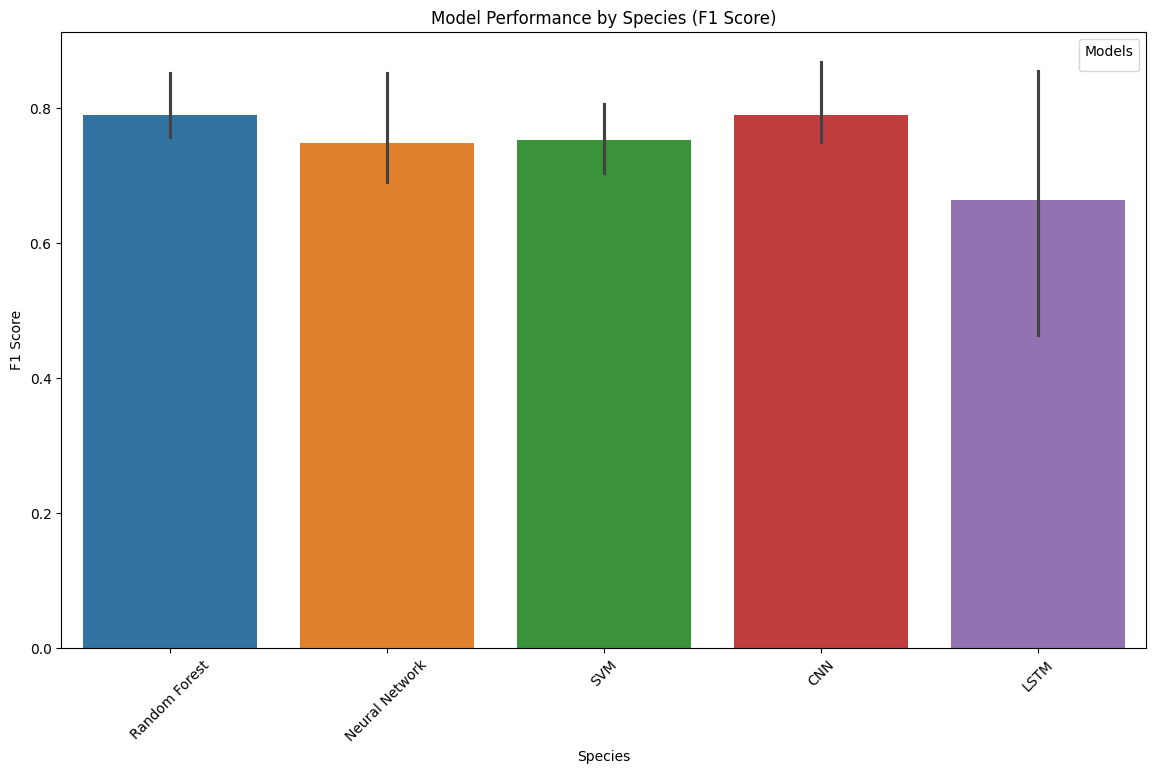

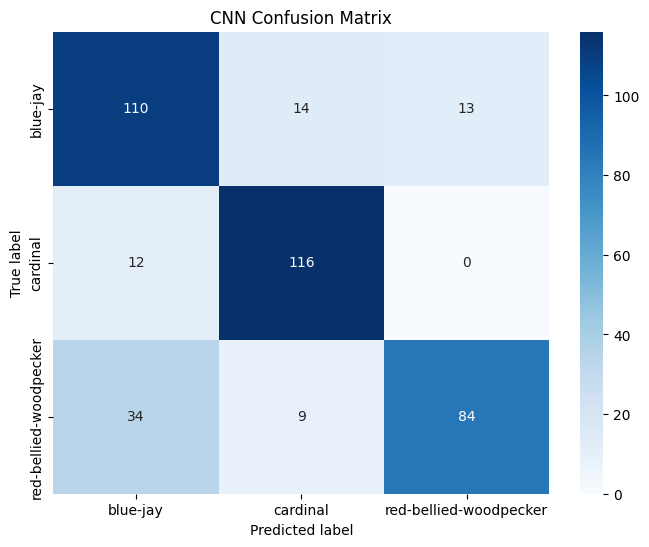

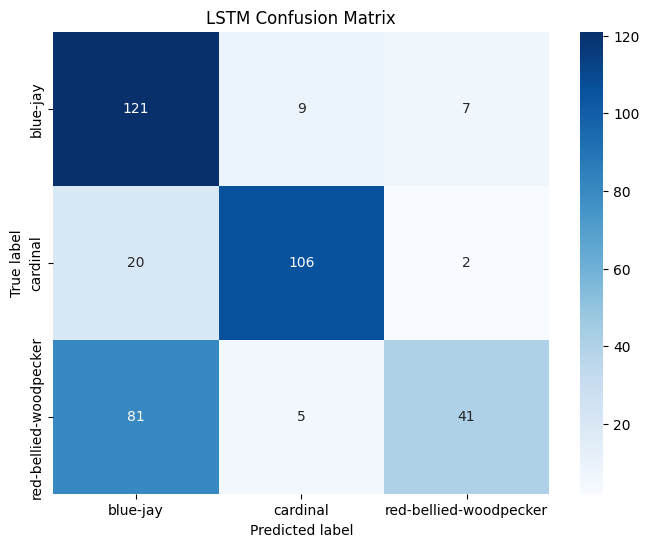

CNN - Precision: 0.80, Recall: 0.79, F1 Score: 0.79
LSTM - Precision: 0.74, Recall: 0.68, F1 Score: 0.66


In [16]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Embedding
from tensorflow.keras.layers import TimeDistributed, Bidirectional

# Define CNN model
def create_cnn_model(input_dim):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')  # Assuming 3 classes for blue-jay, cardinal, and red-bellied-woodpecker
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define LSTM model
def create_lstm_model(input_dim):
    model = Sequential([
        LSTM(128, input_shape=(None, input_dim), return_sequences=True),
        Dropout(0.3),
        LSTM(128),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Reshape data for CNN (adding a dimension)
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

# Train CNN Classifier
cnn_model = create_cnn_model(X_train_cnn.shape[1])
cnn_model.fit(X_train_cnn, y_train_encoded, epochs=1000, batch_size=32, verbose=1)
cnn_predictions = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
cnn_accuracy = accuracy_score(y_test_encoded, cnn_predictions)
cnn_report = classification_report(y_test_encoded, cnn_predictions, target_names=species, output_dict=True, zero_division=0)

# Reshape data for LSTM (adding time steps, here each embedding is treated as a time step)
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

# Train LSTM Classifier
lstm_model = create_lstm_model(X_train_lstm.shape[2])
lstm_model.fit(X_train_lstm, y_train_encoded, epochs=30, batch_size=32, verbose=1)
lstm_predictions = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
lstm_accuracy = accuracy_score(y_test_encoded, lstm_predictions)
lstm_report = classification_report(y_test_encoded, lstm_predictions, target_names=species, output_dict=True, zero_division=0)

# Print reports for CNN and LSTM
print("\nCNN Classifier Report:")
print(classification_report(y_test_encoded, cnn_predictions, target_names=species, zero_division=0))
print("Accuracy:", cnn_accuracy)

print("\nLSTM Classifier Report:")
print(classification_report(y_test_encoded, lstm_predictions, target_names=species, zero_division=0))
print("Accuracy:", lstm_accuracy)

# Prepare data for species-level performance plotting
performance_by_species = {
    'Random Forest': [rf_report[species[i]]['f1-score'] for i in range(len(species))],
    'Neural Network': [nn_report[species[i]]['f1-score'] for i in range(len(species))],
    'SVM': [svm_report[species[i]]['f1-score'] for i in range(len(species))],
    'CNN': [cnn_report[species[i]]['f1-score'] for i in range(len(species))],
    'LSTM': [lstm_report[species[i]]['f1-score'] for i in range(len(species))]
}

# Convert to DataFrame for plotting
df_performance = pd.DataFrame(performance_by_species, index=species)

# Plotting species-level performance
plt.figure(figsize=(14, 8))
sns.barplot(data=df_performance)
plt.title('Model Performance by Species (F1 Score)')
plt.ylabel('F1 Score')
plt.xlabel('Species')
plt.xticks(rotation=45)
plt.legend(title='Models')
plt.show()

# Confusion matrices for CNN and LSTM
cnn_cm = confusion_matrix(y_test_encoded, cnn_predictions)
lstm_cm = confusion_matrix(y_test_encoded, lstm_predictions)

plot_confusion_matrix(cnn_cm, species, title='CNN Confusion Matrix')
plot_confusion_matrix(lstm_cm, species, title='LSTM Confusion Matrix')

# Additional performance stats for CNN and LSTM
print_additional_stats(y_test_encoded, cnn_predictions, "CNN")
print_additional_stats(y_test_encoded, lstm_predictions, "LSTM")


## Visualization of Model Performance

To better understand how each model performs across different bird species, we will visualize the F1 scores for each species using bar plots. This will help us compare the effectiveness of each classification model (Random Forest, Neural Network, SVM, CNN, LSTM) in identifying the bird species (Blue Jay, Cardinal, and Red-bellied Woodpecker). By plotting the performance, we can gain insights into which models perform best for each species and overall. The F1 score is chosen as it provides a balanced measure of precision and recall, making it a comprehensive metric for evaluating model performance.

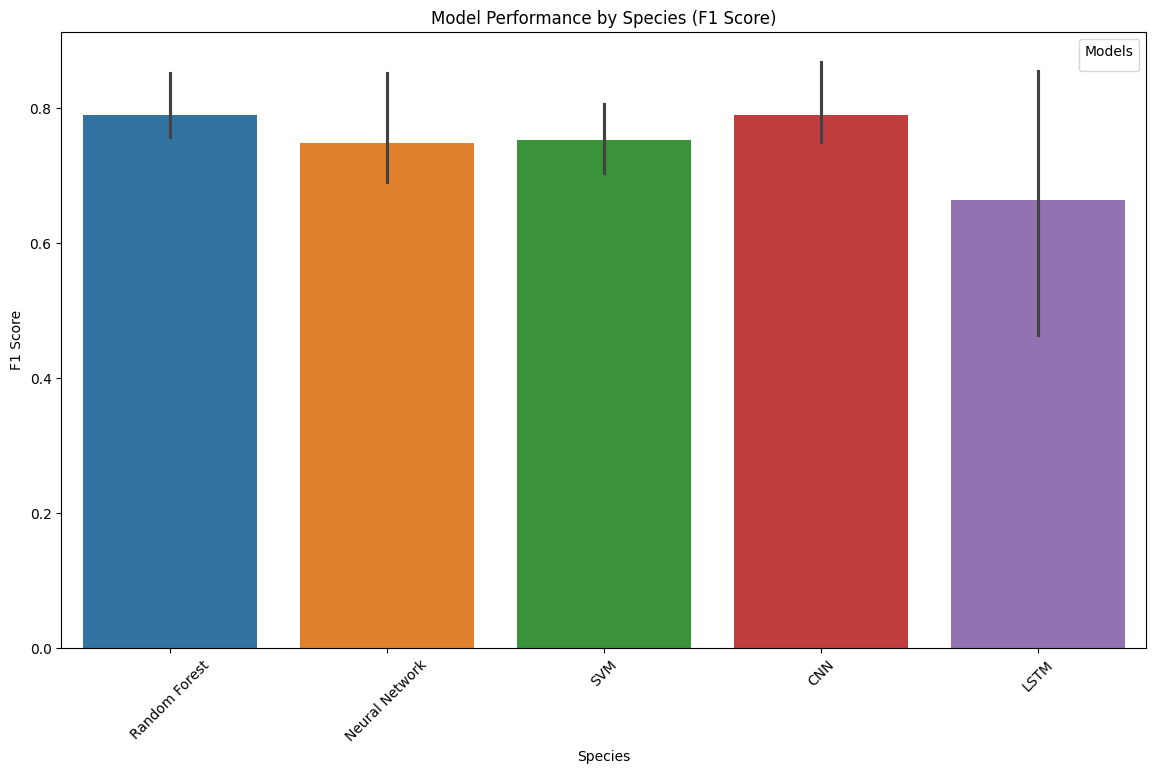

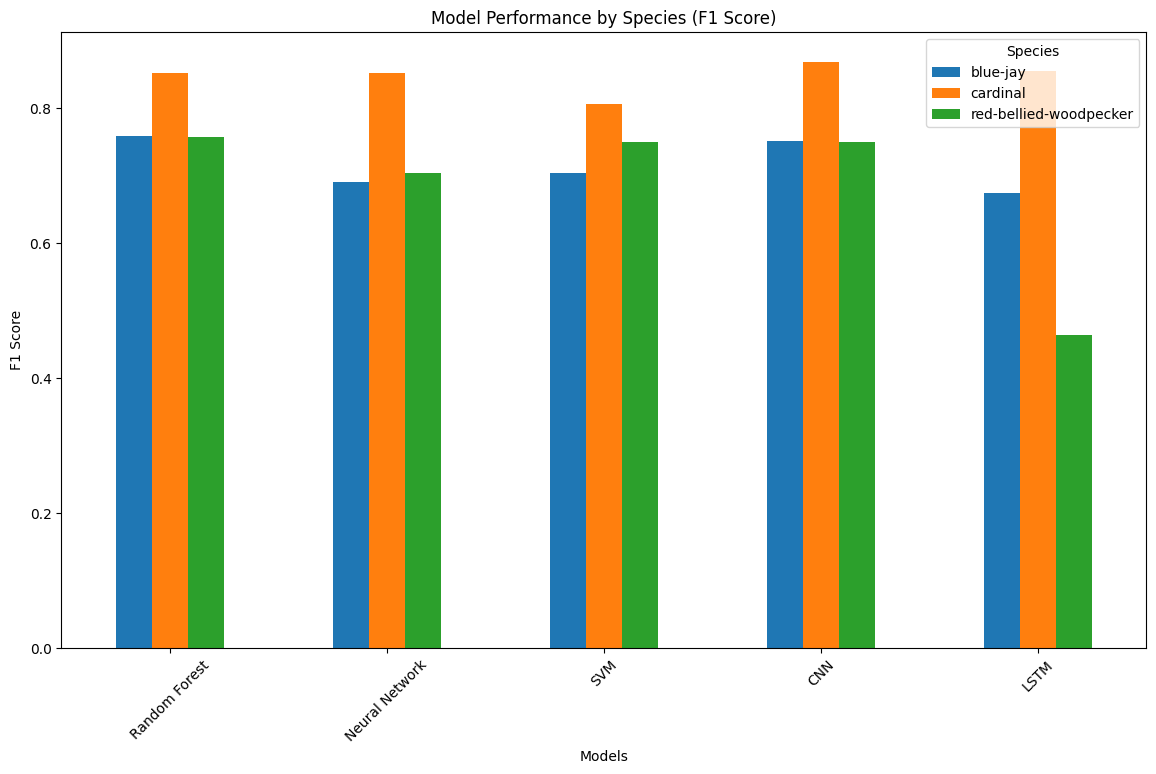

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for species-level performance plotting
performance_by_species = {
    'Random Forest': [rf_report[species[i]]['f1-score'] for i in range(len(species))],
    'Neural Network': [nn_report[species[i]]['f1-score'] for i in range(len(species))],
    'SVM': [svm_report[species[i]]['f1-score'] for i in range(len(species))],
    'CNN': [cnn_report[species[i]]['f1-score'] for i in range(len(species))],
    'LSTM': [lstm_report[species[i]]['f1-score'] for i in range(len(species))]
}

# Convert to DataFrame for plotting
df_performance = pd.DataFrame(performance_by_species, index=species)

# Plotting species-level performance vertically
plt.figure(figsize=(14, 8))
sns.barplot(data=df_performance)
plt.title('Model Performance by Species (F1 Score)')
plt.ylabel('F1 Score')
plt.xlabel('Species')
plt.xticks(rotation=45)
plt.legend(title='Models')
plt.show()

# Plotting species-level performance horizontally
df_performance.T.plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance by Species (F1 Score)')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(title='Species')
plt.show()


# Unsupervised Learning Techniques

In this section, we will evaluate various clustering models to group bird call embeddings. We will use models such as KMeans, KMedoids, Gaussian Mixture Model (GMM), Birch, and Spectral Clustering. Each model will be assessed using metrics like silhouette score, adjusted Rand Index (ARI), and clustering accuracy. These metrics will help us understand how well the models group the embeddings and how closely these groups match the true labels.

The clustering models will be evaluated by encoding the labels into numerical values and ensuring the embeddings and labels are correctly aligned. We will then fit each model to the data and compute the evaluation metrics. Additionally, we will visualize the performance of each clustering model by plotting the accuracy for each bird species, both vertically and horizontally. This visualization will provide insights into how well each model performs in clustering the bird call embeddings for Blue Jay, Cardinal, and Red-bellied Woodpecker.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



KMeans Clustering Report:
Silhouette Score: 0.13
Adjusted Rand Index: 0.12
Accuracy: 0.52

KMedoids Clustering Report:
Silhouette Score: 0.09
Adjusted Rand Index: 0.14
Accuracy: 0.49

GMM Clustering Report:
Silhouette Score: 0.13
Adjusted Rand Index: 0.10
Accuracy: 0.51

Birch Clustering Report:
Silhouette Score: 0.11
Adjusted Rand Index: 0.16
Accuracy: 0.54


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



SpectralClustering Clustering Report:
Silhouette Score: -0.00
Adjusted Rand Index: 0.00
Accuracy: 0.35


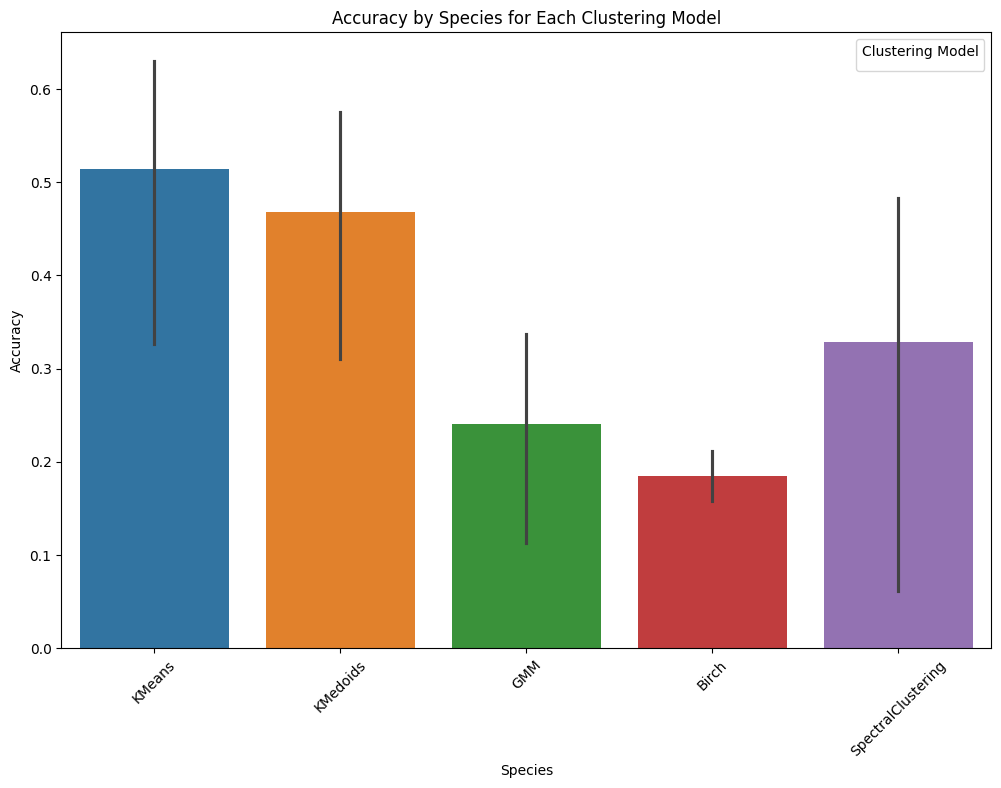

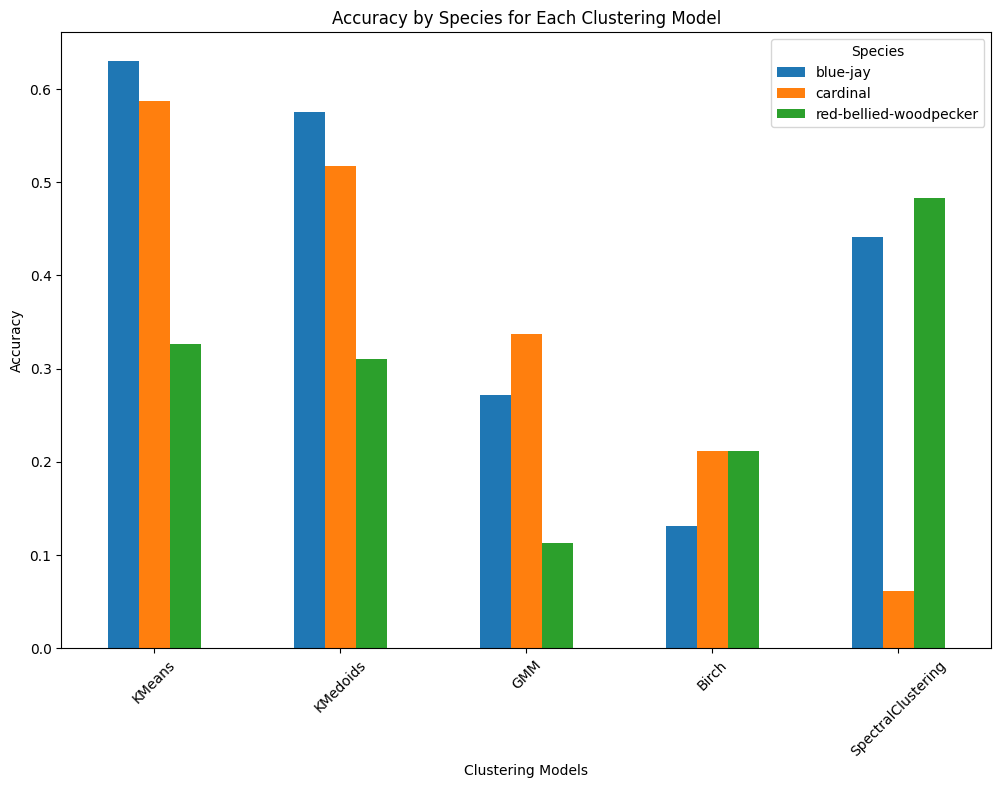

In [9]:
!pip install -q scikit-learn-extra

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch, SpectralClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)  # Encode the labels

# Ensure df_embeddings and y_encoded are aligned
assert df_embeddings.shape[0] == len(y_encoded), "Number of samples in df_embeddings and y_encoded must be the same."

# Define the clustering models
clustering_models = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'KMedoids': KMedoids(n_clusters=3, random_state=42),
    'GMM': GaussianMixture(n_components=3, random_state=42),
    'Birch': Birch(n_clusters=3),
    'SpectralClustering': SpectralClustering(n_clusters=3, random_state=42, assign_labels='discretize')
}

# Function to evaluate clustering
def evaluate_clustering(model, X, y_true):
    y_pred = model.fit_predict(X)
    score = silhouette_score(X, y_pred) if len(set(y_pred)) > 1 else float('nan')
    ari = adjusted_rand_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(3))
    return y_pred, score, ari, cm

# Function to calculate clustering accuracy
def clustering_accuracy(y_true, y_pred):
    """
    Calculate the accuracy of the clustering by finding the best one-to-one mapping
    between cluster labels and true labels using the Hungarian algorithm.
    """
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) / y_pred.size

# Evaluate and collect results
results = {}
for model_name, model in clustering_models.items():
    y_pred, score, ari, cm = evaluate_clustering(model, df_embeddings, y_encoded)
    accuracy = clustering_accuracy(y_encoded, y_pred)

    print(f"\n{model_name} Clustering Report:")
    print(f"Silhouette Score: {score:.2f}")
    print(f"Adjusted Rand Index: {ari:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    results[model_name] = {
        'Silhouette Score': score,
        'Adjusted Rand Index': ari,
        'Accuracy': accuracy,
        'Confusion Matrix': cm
    }

# Plot accuracy by species for each model
accuracy_by_species = {model_name: [] for model_name in clustering_models.keys()}

for model_name, result in results.items():
    cm = result['Confusion Matrix']
    for i, species_name in enumerate(species):
        accuracy_by_species[model_name].append(cm[i, i] / cm[i].sum())

species_accuracy_df = pd.DataFrame(accuracy_by_species, index=species)

# Plotting species-level performance vertically
plt.figure(figsize=(12, 8))
sns.barplot(data=species_accuracy_df)
plt.title('Accuracy by Species for Each Clustering Model')
plt.ylabel('Accuracy')
plt.xlabel('Species')
plt.xticks(rotation=45)
plt.legend(title='Clustering Model')
plt.show()

# Plotting species-level performance horizontally
species_accuracy_df.T.plot(kind='bar', figsize=(12, 8))
plt.title('Accuracy by Species for Each Clustering Model')
plt.ylabel('Accuracy')
plt.xlabel('Clustering Models')
plt.xticks(rotation=45)
plt.legend(title='Species')
plt.show()
